In [1]:
import numpy as np
import math
import pandas
import geopandas
import networkx as nx
import osmnx as ox
# from shapely.geometry import LineString, mapping, Polygon
import shapely
# import shapely.geometry
import geopandas as gpd
from ipyleaflet import *
from ipywidgets import Layout
import geopy.distance
import contextily
import matplotlib.pyplot


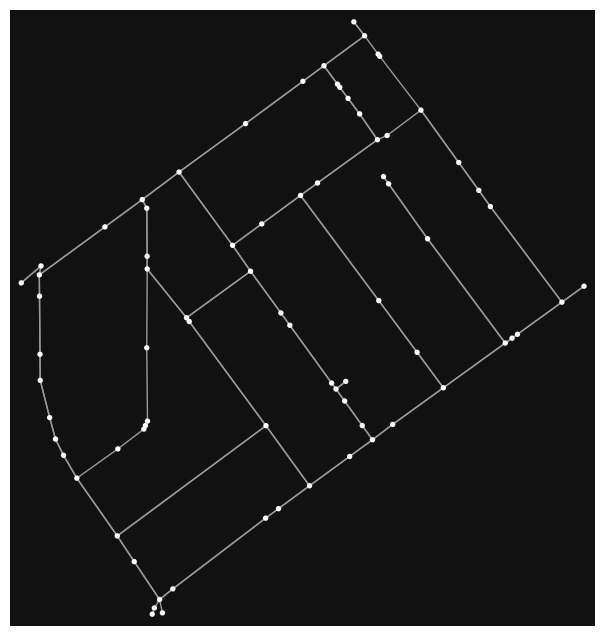

In [2]:
# Create polygon from lists of points
x = [4.347663, 4.352337, 4.349946, 4.346000, 4.346000]
y = [52.006884, 52.008783, 52.010765, 52.009467, 52.008111]

place_polygon = shapely.geometry.Polygon(zip(x,y))
# Retrieve the network graph
graph = ox.graph_from_polygon(
    # place_polygon.at[0, "geometry"],
    place_polygon,
    network_type="drive_service",
    simplify=False
)

fig, ax = ox.plot_graph(graph)

In [3]:
nodes, edges = ox.graph_to_gdfs(graph)

osmid                    name      highway  \
u           v          key                                                   
44831868    44835264   0      7542013   Isaäk Hoornbeekstraat  residential   
            44833576   0    426609449           Westplantsoen     tertiary   
            1513178337 0    426609449           Westplantsoen     tertiary   
44833175    44835264   0      7542074        Jacob Catsstraat  residential   
            4820768561 0     46929879     Hugo de Grootstraat     tertiary   
...                               ...                     ...          ...   
9730237179  44844068   0    144081616  Verlengde Singelstraat  residential   
10189468151 44835255   0    426609449           Westplantsoen     tertiary   
            1516915116 0    426609449           Westplantsoen     tertiary   
10877175239 44838791   0      7542074        Jacob Catsstraat  residential   
            44835264   0      7542074        Jacob Catsstraat  residential   

                           maxspeed  oneway  reversed   length  \
u           v          key                                       
44831868    44835264   0         30   False     False  129.974   
            44833576   0         50   False     False   49.491   
            1513178337 0         50   False      True   21.632   
44833175    44835264   0         30   False     False   52.090   
            4820768561 0         50   False     False   34.896   
...                             ...     ...       ...      ...   
9730237179  44844068   0         30    True     False   29.699   
10189468151 44835255   0         50   False     False   15.634   
            1516915116 0         50   False      True   12.691   
10877175239 44838791   0         30   False     False    3.224   
            44835264   0         30   False      True   90.890   

                                                                   geometry  
u           v          key                                                   
44831868    44835264   0    LINESTRING (4.34729 52.00742, 4.34882 52.00811)  
            44833576   0    LINESTRING (4.34729 52.00742, 4.34688 52.00778)  
            1513178337 0    LINESTRING (4.34729 52.00742, 4.34746 52.00726)  
44833175    44835264   0    LINESTRING (4.34926 52.00773, 4.34882 52.00811)  
            4820768561 0    LINESTRING (4.34926 52.00773, 4.34967 52.00792)  
...                                                                     ...  
9730237179  44844068   0    LINESTRING (4.35006 52.00995, 4.35041 52.01011)  
10189468151 44835255   0    LINESTRING (4.34666 52.00803, 4.34660 52.00816)  
            1516915116 0    LINESTRING (4.34666 52.00803, 4.34674 52.00793)  
10877175239 44838791   0    LINESTRING (4.34803 52.00877, 4.34800 52.00880)  
            44835264   0    LINESTRING (4.34803 52.00877, 4.34882 52.00811)  

[156 rows x 8 columns]

In [4]:
# Retrieve edges & nodes from the graph
#collect data with real distance of the road
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)
lengthdict = nx.get_edge_attributes(graph, 'length')

In [5]:
df = pandas.DataFrame.from_dict(lengthdict, orient='index', columns=['length'])
df.reset_index(inplace=True)
df = df.rename(columns={"index": "edges"})

In [6]:
while(1):
    user_input = input("Car or Truck (Case-sensitve)")
    if user_input == "Car" or user_input == "Truck":
        break
    print(f"Please fill in either Car or Truck and not '{user_input}'")

In [7]:
df['useful-width'] = np.random.uniform(0.3, 12.0, size=len(df)).round(2)
df['K'] = 1 / df['useful-width']
df['1/K'] = np.log(df['K'])
if user_input == "Car":
    df.loc[df['useful-width'] < 3.00, 'K-corrected'] = 999
    df.loc[df['useful-width'] >= 3.00, 'K-corrected'] = df['K']
else:
    df.loc[df['useful-width'] < 4.5, 'K-corrected'] = 999
    df.loc[df['useful-width'] >= 4.5, 'K-corrected'] = df['K']
df['weight'] = df['length'] * df['K-corrected']

In [8]:
d_K = dict(zip(df['edges'], df['K']))
d_useful_width = dict(zip(df['edges'], df['useful-width']))
d_weight = dict(zip(df['edges'], df['weight']))

nx.set_edge_attributes(graph, d_weight, 'weight')
nx.set_edge_attributes(graph, d_K, 'K')
nx.set_edge_attributes(graph, d_useful_width, 'useful-width')

In [9]:
#Backup
graphInter = graph.copy()
edgesInter = edges.copy()
nodesInter = nodes.copy()

In [10]:
# Transform the graph to UTM
graph = ox.project_graph(graph) 

# Extract reprojected nodes and edges
nodes, edges = ox.graph_to_gdfs(graph)

In [11]:
convex_hull = edges.unary_union.convex_hull
stats = ox.basic_stats(graph, area=convex_hull.area)

In [12]:
origin = (
    ox.geocode_to_gdf("Frits Diepenlaan", which_result=1)  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    ox.geocode_to_gdf("prunusstraat, schipluiden", which_result=1)
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

In [13]:
origin_node_id = ox.nearest_nodes(graph, origin.x, origin.y)
destination_node_id = ox.nearest_nodes(graph, destination.x, destination.y)
# Find the shortest path between origin and destination
route = nx.shortest_path(graph, origin_node_id, destination_node_id, 'weight', method='dijkstra')

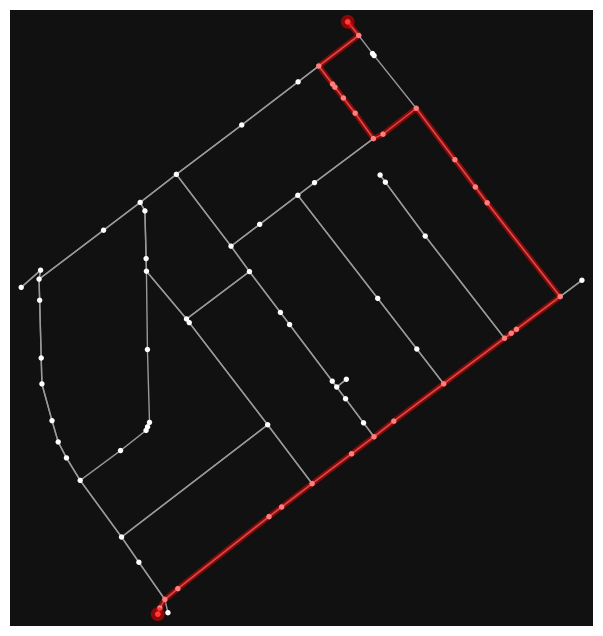

In [14]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(graph, route)

In [15]:
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]

In [16]:
# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)

In [17]:
route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

In [18]:
buildings = ox.features_from_polygon(
    place_polygon,
    {
        "building" : True
    }
).to_crs(edges.crs)

In [19]:
fig, ax = matplotlib.pyplot.subplots(figsize=(24,16))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=3, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)



In [ ]:
#convert x,y value into (u,v,k) format
ox.distance.nearest_edges(graph, 4.3708, 52.00478, interpolate=None, return_dist=False)

(1010679591, 6883743181, 0)

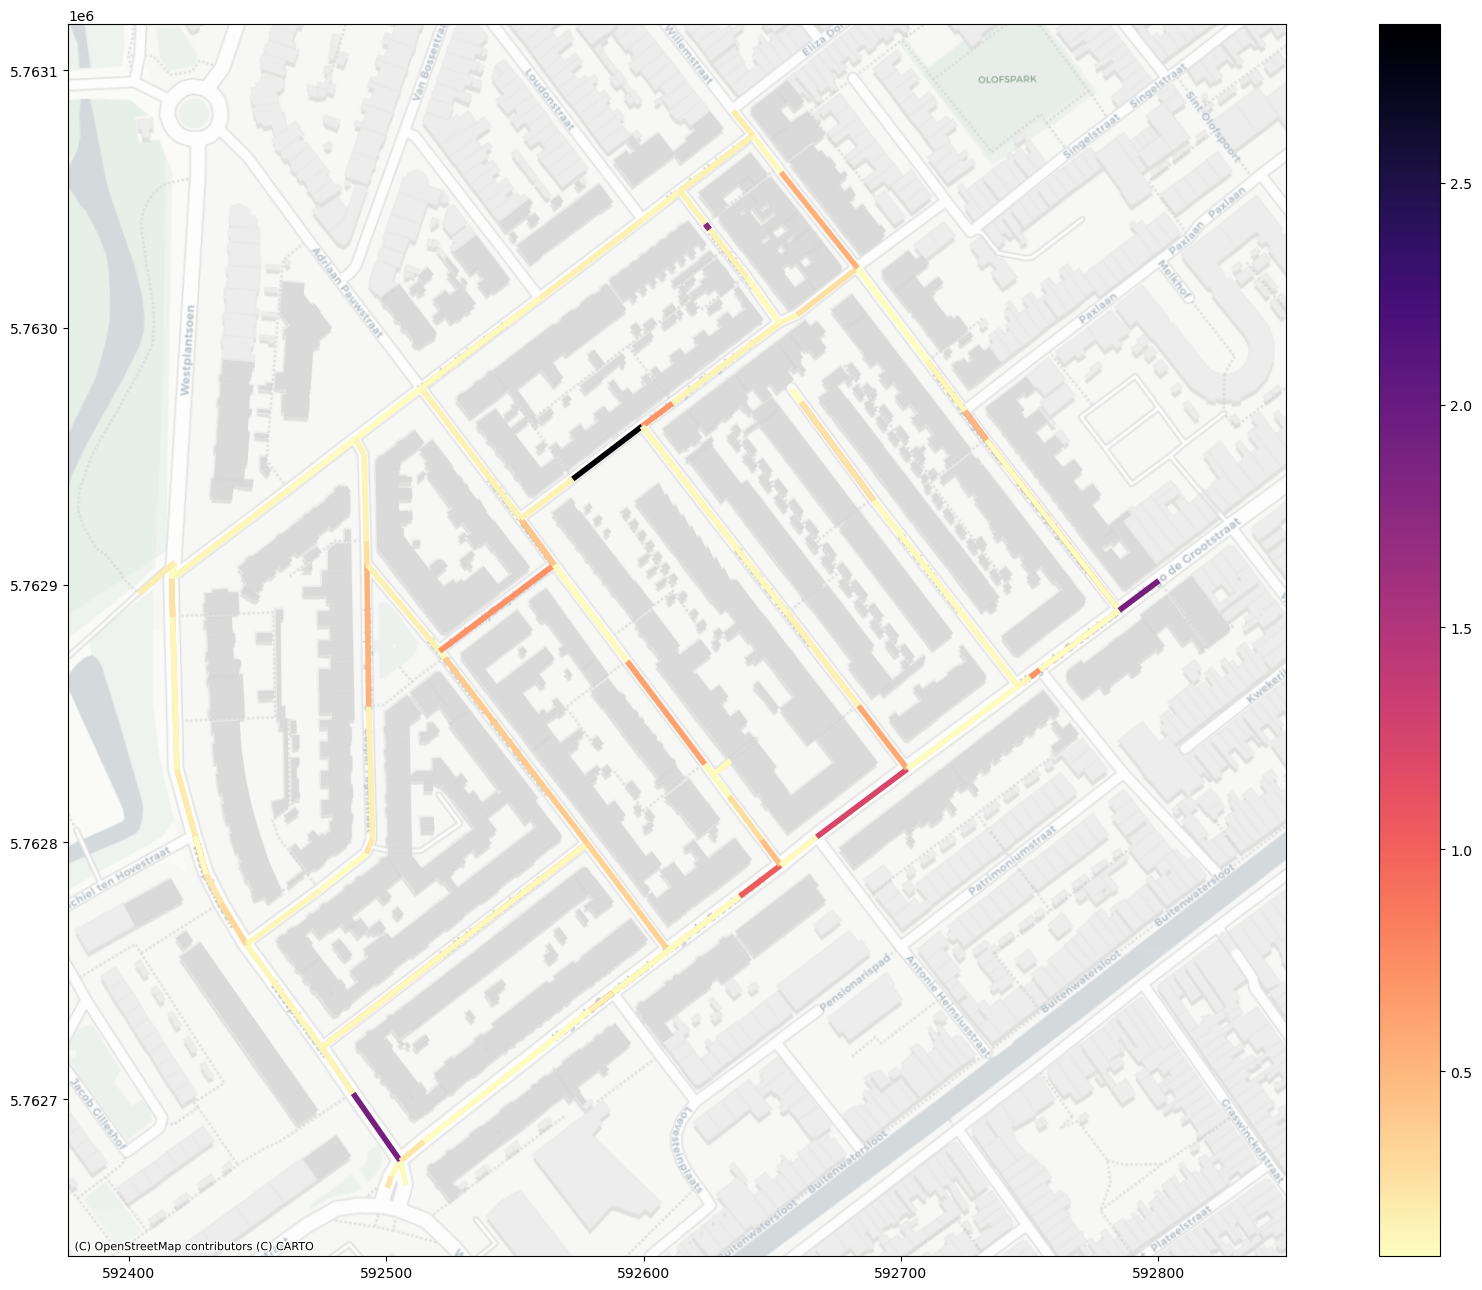

In [ ]:
# visuallization of 'weight 

ax = edges.plot(column="K", figsize=(24,16), legend=True, cmap='magma_r', linewidth=4)

# # Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# # Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)


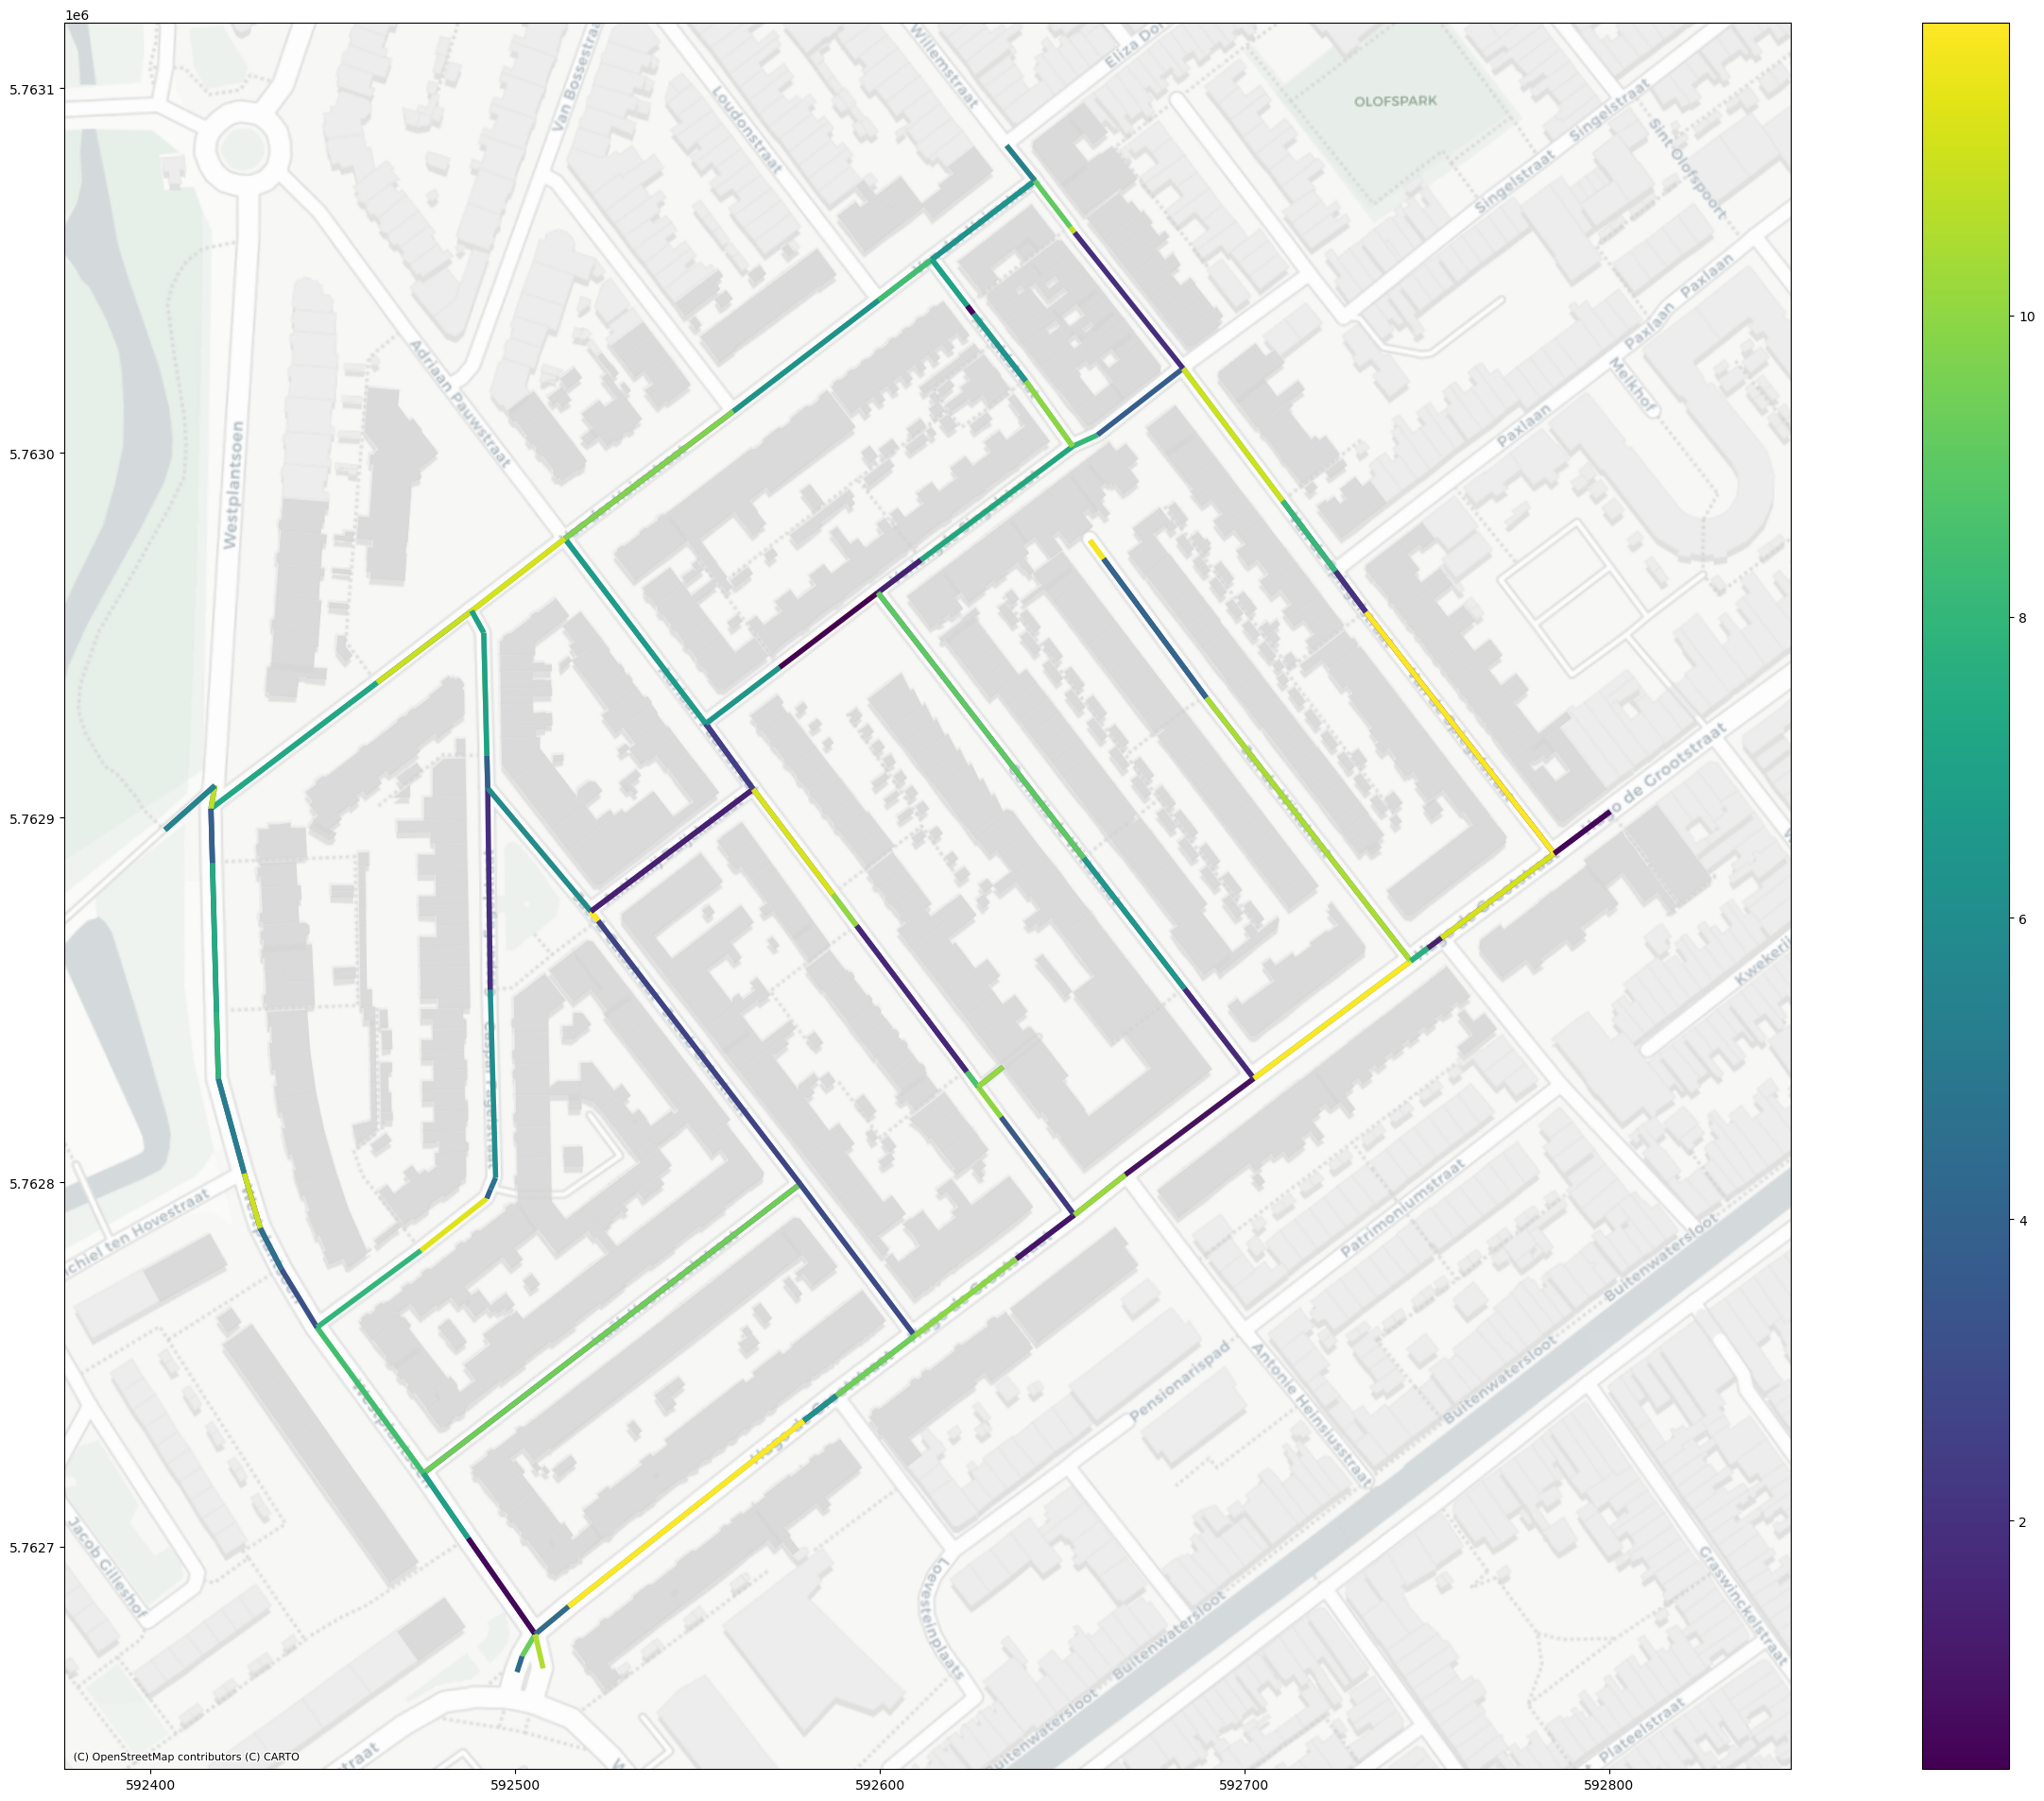

In [ ]:
# visuallization of 'weight 

ax = edges.plot(column="useful-width", figsize=(36,24), legend=True, cmap='viridis', linewidth=4)

# # Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# # Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)


In [ ]:
center = (52.008879, 4.349493)
m = Map(center=center, basemap=basemaps.CartoDB.Positron, zoom=17, layout=Layout(width='100%', height='600px'))

In [ ]:
#style for the destination marker
to_marker_style = AwesomeIcon(
    name='circle',
    icon_color='white',
    marker_color='red',
    spin=False
)
from_marker = Marker(location=center)      # start point = BLUE marker
to_marker = Marker(location=center, icon=to_marker_style)    # end point = RED marker


In [ ]:
data = {
  "latitude-y": [52.008236, 52.009476, 52.008471, 52.009309, 52.010014, 52.009187, 52.008176, 52.010223, 52.008886, 52.00891, 52.008435, 52.008528, 52.009221, 52.009552, 52.007444, 52.010052],
  "longtitude-x": [4.347604, 4.348983, 4.349382, 4.350463, 4.349797, 4.348506, 4.348769, 4.349579, 4.347581, 4.347854, 4.349408, 4.34653, 4.346558, 4.347525, 4.347285, 4.348678]
}
#the data above should be created based on QGIS filter in step1
#load data into a DataFrame object:
df_assembly = pandas.DataFrame(data)
lst_assembly = [tuple(r) for r in df_assembly.to_numpy()]

data = {
  "latitude-y": [52.009229, 52.007505, 52.010029, 52.009242],
  "longtitude-x": [4.346595, 4.347407, 4.350257, 4.351449]
}
#the data above should be created based on QGIS filter in step1
#load data into a DataFrame object:
df_shelter = pandas.DataFrame(data)
lst_shelter = [tuple(r) for r in df_assembly.to_numpy()]


In [ ]:
def find(marker, lst):
    temp_shortest = 999999
    temp_ind = 0
    for i in lst:
        coord_1 = (marker.location[0], marker.location[1]) #(y,x)
        coord_2 = (float(i[0]), float(i[1])) #(y,x)
        temp_dis = geopy.distance.geodesic(coord_1, coord_2) #count the distance accoring to lat and long
        if temp_dis < temp_shortest:
            temp_shortest = temp_dis
            temp_ind = lst.index(i)
    nearest_shelter = ox.nearest_nodes(graphInter, float(lst[temp_ind][1]), float(lst[temp_ind][0])) 
    return nearest_shelter

In [ ]:
path_layer_list = []
def handle_change_location(event, marker, lst1, lst2):
    event_owner = event['owner']
    shortest_path = nx.dijkstra_path(graphInter, find(event_owner, lst1), find(marker, lst2), 
                                     weight='weight')
    if len(path_layer_list) == 1:
        m.remove(path_layer_list[0])
        path_layer_list.pop()
    
    shortest_path_points = nodesInter.loc[shortest_path]
    path = gpd.GeoDataFrame([LineString(shortest_path_points.geometry.values)], columns=['geometry'])
    path_layer = GeoData(geo_dataframe=path, style={'color':'red', 'weight':2})
    m.add(path_layer)
    path_layer_list.append(path_layer)

In [ ]:
from_marker.observe(lambda event: handle_change_location(event, to_marker, lst_assembly, lst_shelter), 'location')
to_marker.observe(lambda event: handle_change_location(event, from_marker, lst_shelter, lst_assembly), 'location')

m.add(from_marker)
m.add(to_marker)

display(m)
 # start point = BLUE marker
 # end point = RED marker

Map(center=[52.008879, 4.349493], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …